[*********************100%***********************]  1 of 1 completed


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

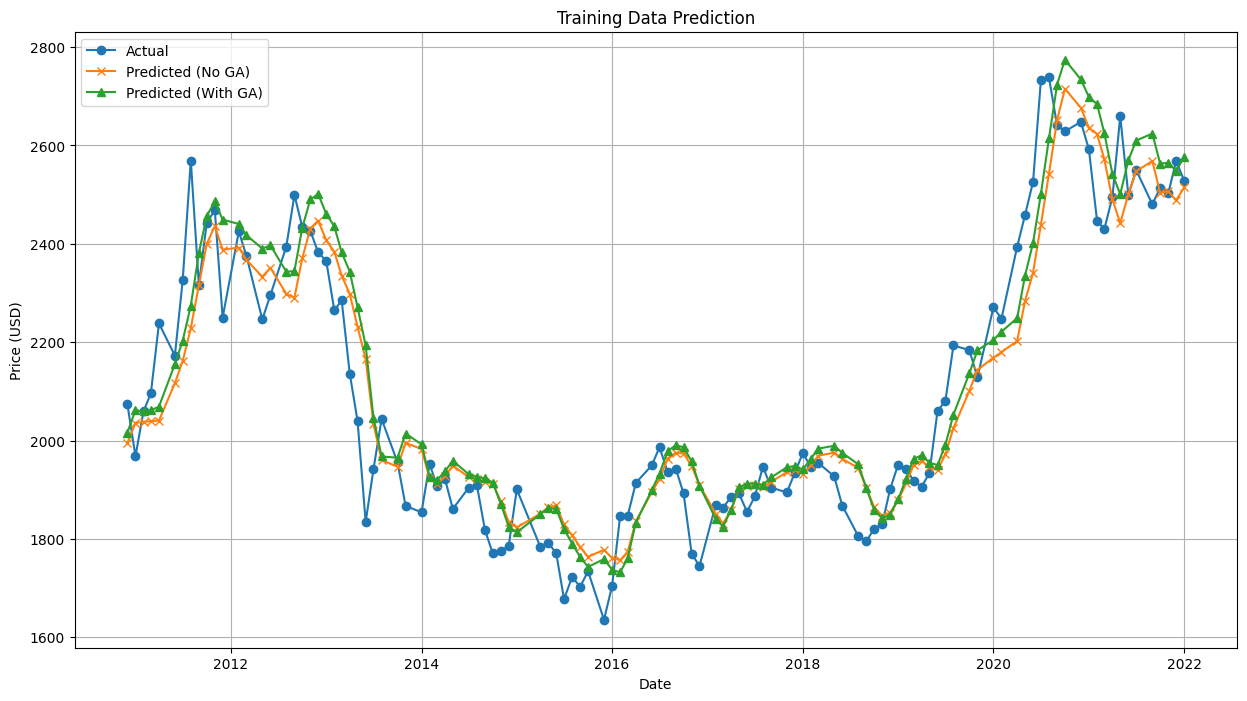

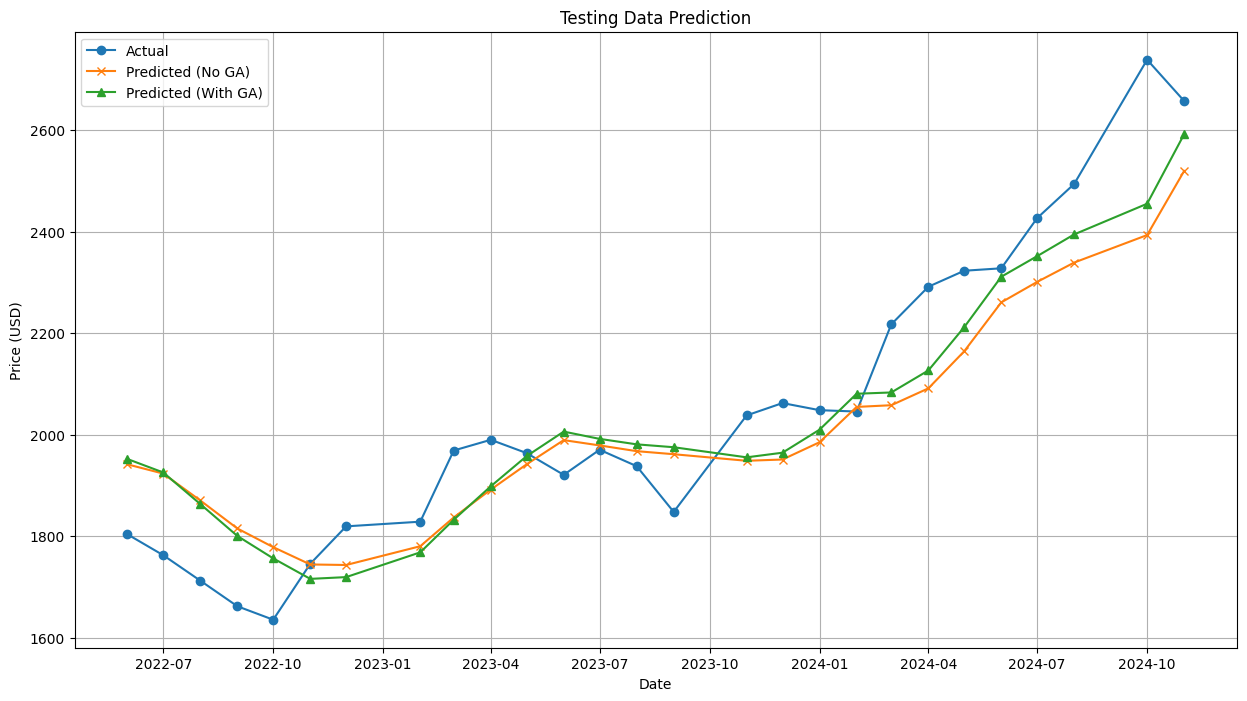


=== Training Data Results ===
          Date       Actual  Predicted (No GA)  Predicted (With GA)
0   2010-12-01  2074.284109        1995.112671          2016.151489
1   2011-01-01  1968.211753        2035.992798          2061.780029
2   2011-02-01  2059.946800        2037.987427          2059.661377
3   2011-03-01  2095.911769        2039.753418          2061.781738
4   2011-04-01  2238.192191        2040.504150          2069.029297
..         ...          ...                ...                  ...
109 2021-09-01  2480.348475        2568.378662          2624.196045
110 2021-10-01  2514.004850        2503.664795          2562.883789
111 2021-11-01  2502.583503        2507.070312          2564.764893
112 2021-12-01  2568.073851        2488.365234          2548.465088
113 2022-01-01  2528.585255        2514.639893          2576.435059

[114 rows x 4 columns]

=== Testing Data Results ===
         Date       Actual  Predicted (No GA)  Predicted (With GA)
0  2022-06-01  1804.099976      

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import set_random_seed
import random
import math

# Konfigurasi GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

set_random_seed(42)
np.random.seed(42)
random.seed(42)

class GeneticAlgorithmOptimizer:
    def __init__(self, population_size, generations, mutation_rate):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate

    def create_population(self):
        return [
            {
                'units': random.randint(32, 128),
                'learning_rate': random.uniform(0.0001, 0.01),
                'batch_size': random.choice([16, 32, 64])
            }
            for _ in range(self.population_size)
        ]

    def mutate(self, individual):
        if random.random() < self.mutation_rate:
            individual['units'] = random.randint(32, 128)
        if random.random() < self.mutation_rate:
            individual['learning_rate'] = random.uniform(0.0001, 0.01)
        if random.random() < self.mutation_rate:
            individual['batch_size'] = random.choice([16, 32, 64])
        return individual

    def crossover(self, parent1, parent2):
        child = {
            'units': parent1['units'] if random.random() < 0.5 else parent2['units'],
            'learning_rate': parent1['learning_rate'] if random.random() < 0.5 else parent2['learning_rate'],
            'batch_size': parent1['batch_size'] if random.random() < 0.5 else parent2['batch_size']
        }
        return self.mutate(child)

    def select_best(self, population, scores, n_best=3):
        sorted_population = [x for _, x in sorted(zip(scores, population))]
        return sorted_population[:n_best]

    def optimize(self, train_data, train_target, val_data, val_target, time_steps):
        population = self.create_population()
        best_model = None
        best_score = float('inf')

        for generation in range(self.generations):
            scores = []
            for individual in population:
                model = Sequential([
                    Input(shape=(time_steps, 1)),
                    LSTM(individual['units']),
                    Dense(1)
                ])
                model.compile(optimizer=Adam(learning_rate=individual['learning_rate']), loss='mse')
                model.fit(train_data, train_target, epochs=10, batch_size=individual['batch_size'], verbose=0)
                val_predict = model.predict(val_data)
                score = mean_squared_error(val_target, val_predict)
                scores.append(score)

                if score < best_score:
                    best_score = score
                    best_model = model

            best_individuals = self.select_best(population, scores)
            new_population = best_individuals
            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(best_individuals, 2)
                new_population.append(self.crossover(parent1, parent2))
            population = new_population

        return best_model

class GoldPredictor:
    def __init__(self, start_date='2010-09-01', end_date='2024-12-01'):
        self.start_date = start_date
        self.end_date = end_date
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        
    def fetch_gold_data(self):
        gold = yf.download('GC=F', start=self.start_date, end=self.end_date, interval='1mo')
        return gold[['Close']]

    def prepare_dataset(self, data, time_steps=3):
        scaled_data = self.scaler.fit_transform(data.values.reshape(-1, 1))
        X, Y = [], []
        for i in range(len(scaled_data) - time_steps):
            X.append(scaled_data[i:(i + time_steps), 0])
            Y.append(scaled_data[i + time_steps, 0])
        return (np.array(X).reshape(-1, time_steps, 1), np.array(Y).reshape(-1, 1))

    def calculate_metrics(self, actual, predicted):
        """
        Menghitung metrik error: MAE, MSE, RMSE
        """
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        rmse = math.sqrt(mse)
        return mae, mse, rmse

    def train_and_compare(self, time_steps=3, test_size=0.2):
        data = self.fetch_gold_data()
        data['Date'] = data.index
        data = data.reset_index(drop=True)
        
        train_size = int(len(data) * (1 - test_size))
        train_data, test_data = data[:train_size], data[train_size:]
        
        X_train, y_train = self.prepare_dataset(train_data['Close'], time_steps)
        X_test, y_test = self.prepare_dataset(test_data['Close'], time_steps)
        
        # Training tanpa GA
        model_no_ga = Sequential([
            Input(shape=(time_steps, 1)),
            LSTM(64),
            Dense(1)
        ])
        model_no_ga.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        model_no_ga.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
        train_predict_no_ga = model_no_ga.predict(X_train)
        test_predict_no_ga = model_no_ga.predict(X_test)
        train_predict_no_ga = self.scaler.inverse_transform(train_predict_no_ga)
        test_predict_no_ga = self.scaler.inverse_transform(test_predict_no_ga)
        
        # Training dengan GA
        ga_optimizer = GeneticAlgorithmOptimizer(population_size=10, generations=10, mutation_rate=0.2)
        model_ga = ga_optimizer.optimize(X_train, y_train, X_test, y_test, time_steps)
        train_predict_ga = model_ga.predict(X_train)
        test_predict_ga = model_ga.predict(X_test)
        train_predict_ga = self.scaler.inverse_transform(train_predict_ga)
        test_predict_ga = self.scaler.inverse_transform(test_predict_ga)
        
        actual_train = self.scaler.inverse_transform(y_train)
        actual_test = self.scaler.inverse_transform(y_test)
        train_dates = train_data['Date'][time_steps:].reset_index(drop=True)
        test_dates = test_data['Date'][time_steps:].reset_index(drop=True)
        
        # Evaluasi metrik untuk training dan testing data
        train_mae_no_ga, train_mse_no_ga, train_rmse_no_ga = self.calculate_metrics(actual_train, train_predict_no_ga)
        test_mae_no_ga, test_mse_no_ga, test_rmse_no_ga = self.calculate_metrics(actual_test, test_predict_no_ga)
        
        train_mae_ga, train_mse_ga, train_rmse_ga = self.calculate_metrics(actual_train, train_predict_ga)
        test_mae_ga, test_mse_ga, test_rmse_ga = self.calculate_metrics(actual_test, test_predict_ga)
        
        print("\n=== Evaluation Without GA ===")
        print(f"Training MAE: {train_mae_no_ga}, MSE: {train_mse_no_ga}, RMSE: {train_rmse_no_ga}")
        print(f"Testing MAE: {test_mae_no_ga}, MSE: {test_mse_no_ga}, RMSE: {test_rmse_no_ga}")
        
        print("\n=== Evaluation With GA ===")
        print(f"Training MAE: {train_mae_ga}, MSE: {train_mse_ga}, RMSE: {train_rmse_ga}")
        print(f"Testing MAE: {test_mae_ga}, MSE: {test_mse_ga}, RMSE: {test_rmse_ga}")
        
        # Buat DataFrame Hasil
        train_results = pd.DataFrame({
            'Date': train_dates,
            'Actual': actual_train.flatten(),
            'Predicted (No GA)': train_predict_no_ga.flatten(),
            'Predicted (With GA)': train_predict_ga.flatten()
        })
        
        test_results = pd.DataFrame({
            'Date': test_dates,
            'Actual': actual_test.flatten(),
            'Predicted (No GA)': test_predict_no_ga.flatten(),
            'Predicted (With GA)': test_predict_ga.flatten()
        })
        
        # Visualisasi
        plt.figure(figsize=(15, 8))
        plt.title('Training Data Prediction')
        plt.plot(train_dates, actual_train, label='Actual', marker='o')
        plt.plot(train_dates, train_predict_no_ga, label='Predicted (No GA)', marker='x')
        plt.plot(train_dates, train_predict_ga, label='Predicted (With GA)', marker='^')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(15, 8))
        plt.title('Testing Data Prediction')
        plt.plot(test_dates, actual_test, label='Actual', marker='o')
        plt.plot(test_dates, test_predict_no_ga, label='Predicted (No GA)', marker='x')
        plt.plot(test_dates, test_predict_ga, label='Predicted (With GA)', marker='^')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.grid(True)
        plt.show()

        return train_results, test_results

def main():
    predictor = GoldPredictor()
    train_results, test_results = predictor.train_and_compare()
    print("\n=== Training Data Results ===")
    print(train_results)
    print("\n=== Testing Data Results ===")
    print(test_results)

if __name__ == "__main__":
    main()
